In [ ]:
!pip install -q transformers datasets librosa sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import os
import re
import random
import itertools
from collections import defaultdict
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt
import pandas as pd

from transformers import MarianMTModel, MarianTokenizer

In [ ]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

## Data augmentation

In [ ]:
device='cuda'
lang = 'en'

lang_to_ru_str = 'Helsinki-NLP/opus-mt-' + lang + '-ru'
ru_to_lang_str = 'Helsinki-NLP/opus-mt-ru-' + lang
ru_to_lang_tokenizer = MarianTokenizer.from_pretrained(ru_to_lang_str)
ru_to_lang_model = MarianMTModel.from_pretrained(ru_to_lang_str).to(device)

lang_to_ru_tokenizer = MarianTokenizer.from_pretrained(lang_to_ru_str)
lang_to_ru_model = MarianMTModel.from_pretrained(lang_to_ru_str).to(device)

# Load MarianMT for Russian-English translation

def backtranslate_russian(text, lang):

    ru_to_lang = ru_to_lang_tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    lang_translation = ru_to_lang_model.generate(**ru_to_lang.to(device))
    lang_text = ru_to_lang_tokenizer.decode(lang_translation[0], skip_special_tokens=True)

    # Translate back to Russian
    lang_to_ru = lang_to_ru_tokenizer(lang_text, return_tensors="pt", truncation=True, padding=True)
    russian_translation = lang_to_ru_model.generate(**lang_to_ru.to(device))
    russian_text = lang_to_ru_tokenizer.decode(russian_translation[0], skip_special_tokens=True)

    return russian_text

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

In [ ]:
def str_cleaner(example):
    example = example.lower()
    example = re.sub(r"[^a-zа-я\d]", " ", example)
    example = re.sub(r"\s+", " ", example)
    example = example.strip()
    return example

In [ ]:
data_train = pd.read_csv("train.csv")
data_train.head()

,text,anger,disgust,fear,joy,sadness,surprise,neutral
0,"Моя любимая еда — это все, что мне не приходил...",0,0,0,0,0,0,1
1,"Теперь, если он покончит с собой, все будут ду...",0,0,0,0,0,0,1
2,КАКОГО НАХРАНА БЭЙЛЕССКАЯ ИЗОИНЦИЯ?,1,0,0,0,0,0,0
3,Чтобы она почувствовала угрозу,0,0,1,0,0,0,0
4,Грязные южные дрочники,1,0,0,0,0,0,0


In [ ]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]
data_train['one_hot_labels'] = data_train.apply(lambda row: [row[col] for col in labels], axis=1)
data_train['unique'] = data_train['one_hot_labels'].apply(lambda x: sum(x) == 1)
data_unique = data_train[(data_train['unique'] == True) \
                         & (data_train['joy'] == 0)\
                         & (data_train['neutral'] == 0)]

data_train = data_train.drop(columns=['one_hot_labels', 'unique'])

In [ ]:
data_train.shape

(43410, 8)

In [ ]:
data_unique.shape

(11516, 10)

In [ ]:
seen = set()
augmented_data = []

for i, j in data_unique.iterrows():
    text = j['text']
    if len(text) < 100:
      seen.add(str_cleaner(text))

      augmented_text = backtranslate_russian(text, lang)
      augmented_clean = str_cleaner(augmented_text)

      if augmented_clean not in seen:
          seen.add(augmented_clean)

          nonzero_index = [index for index, value in enumerate(j['one_hot_labels']) if value != 0][0]
          data_to_add = {
                          'text': augmented_text,
                          'anger': 0,
                          'disgust': 0,
                          'fear': 0,
                          'joy': 0,
                          'sadness': 0,
                          'surprise': 0,
                          'neutral': 0
                      }

          data_to_add[labels[nonzero_index]] = 1
          data_train.loc[len(data_train)] = data_to_add

In [ ]:
data_train.to_csv('data_augmentation_v2.csv', index=False)

In [ ]:
data_train.shape

(50745, 8)

#### 🌀 Загружаем данные (предварительно загрузите их с диска в Google Colab)

[Ссылка на данные](https://disk.yandex.ru/d/awG8jCY01BGcAQ)

In [ ]:
labels = ["anger", "disgust", "fear", "joy", "sadness", "surprise", "neutral"]

data = load_dataset("csv", data_files={"train": "data_augmentation_v2.csv", "validation": "valid.csv"})
data

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 50745
    })
    validation: Dataset({
        features: ['text', 'anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral'],
        num_rows: 5426
    })
})

#### 🔎 Выведем уникальные символы в сплитах

In [ ]:
def get_alphabet(data_split):
    alphabet = set()
    for sample in data_split:
        uniq_chars = set(sample["text"])
        alphabet.update(uniq_chars)
    return alphabet

print("Train unique symbols: ", get_alphabet(data["train"]))
print("Valid unique symbols: ", get_alphabet(data["validation"]))

Train unique symbols:  {'🏊', '👉', '🤗', '😝', '⣾', '©', '😔', '병', 'Р', 'ю', '⣇', '⠘', '☆', '你', 'ñ', '💗', '🤠', '⠳', '😇', 'ь', '💎', 'G', '⢻', '🤨', '🍁', 'A', '💰', '☕', 'Ь', '🤓', '€', 'r', '⭐', '😁', '😏', 'ʌ', '”', 'f', '🙎', 'У', 'Л', 'D', '–', 'V', '🏿', '🍍', 'w', '¦', '\xa0', '✨', '🦗', '⚡', '🎶', 'З', '⠻', 'О', '⣴', 'q', '🔪', '😑', '💜', '查', 'ы', 'Ó', '⚰', 'Й', '⢰', '💸', 'ē', '🤞', 'Щ', '😗', '🐊', '🙏', '⠏', '👻', '무', '5', '🤕', '@', '…', 'K', '🌟', '}', '🇺', '☹', '🤘', '😠', '«', '🦈', '⣘', '⠁', 'л', '！', '√', '🍀', '⡜', '\u200b', 'ı', '🚒', '🤯', '🍧', '✊', 'А', '🚀', '⡆', '⚔', '🙋', '▫', 'П', '⠀', '💥', 'ш', '>', '😘', 'Ч', '?', '☝', '⠫', '🏈', 'C', '⠃', '💓', '💔', '😢', '😒', '№', 'н', '✌', ';', '+', 'Х', 'ī', '“', 'ʖ', '👍', '💙', 'Δ', '⡷', '🤦', '⠙', '<', '在', ')', '😹', 'Н', '🇫', 'e', '😻', '加', '⠈', 'ツ', 'к', '🌿', '✔', 'з', 'I', '🎣', 'щ', '油', 'N', 'р', '😟', '👨', 'U', 'E', '🥀', '中', ' ', 'ň', '&', 'ё', '♫', '🕺', '⠾', '🚫', '9', '📚', '么', '#', '😖', '🤷', '👴', '⣀', '😿', '⠉', '😂', '💩', 'ж', '⣄', 'o', 'т', 'k', '😭'

#### 📊 Построим гистограммы распределения

In [ ]:
def plot_histogram(data_split):
    class_counts = {
        'anger': 0,
        'disgust': 0,
        'fear': 0,
        'joy': 0,
        'sadness': 0,
        'surprise': 0,
        'neutral': 0
    }

    for sample in data_split:
        for emotion in labels:
            class_counts[emotion] += sample[emotion]

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    plt.bar(classes, counts)
    plt.xlabel('Классы эмоций')
    plt.ylabel('Количество')
    plt.title('Распределение по классам эмоций')
    plt.xticks(rotation=45)

    plt.show()

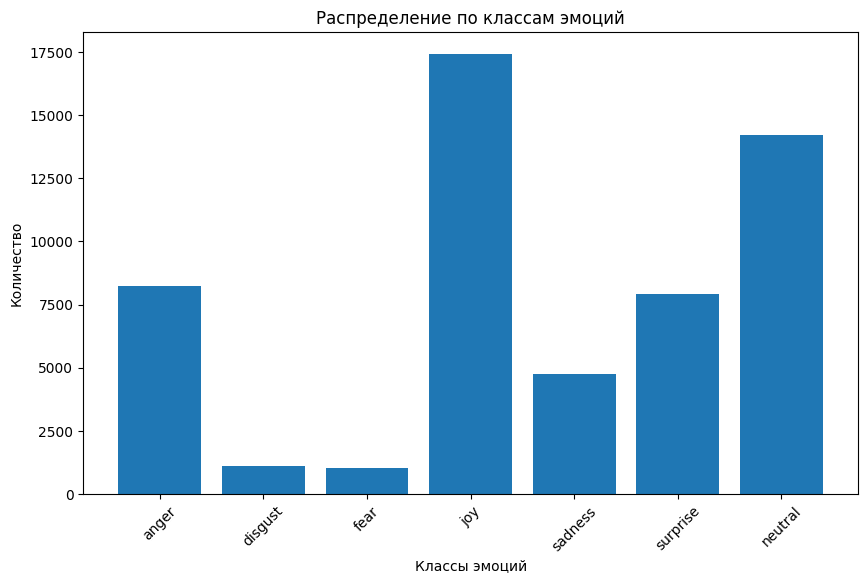

In [ ]:
plot_histogram(data["train"])

In [ ]:
def plot_combined_emotions(data_split):
    emotion_pairs = defaultdict(int)

    for entry in data_split:
        emotions = {key: value for key, value in entry.items() if key in labels}
        active_emotions = [emotion for emotion, value in emotions.items() if value > 0]

        for pair in itertools.combinations(sorted(active_emotions), 2):
            emotion_pairs[pair] += 1

    sorted_pairs = sorted(emotion_pairs.items(), key=lambda x: x[1], reverse=True)
    pairs = [f"{pair[0]} & {pair[1]}" for pair, _ in sorted_pairs]
    counts = [count for _, count in sorted_pairs]

    plt.figure(figsize=(12, 6))
    plt.bar(pairs, counts)
    plt.xlabel('Пары эмоций')
    plt.ylabel('Количество')
    plt.title('Совместное появление эмоций')
    plt.xticks(rotation=45)

    plt.show()

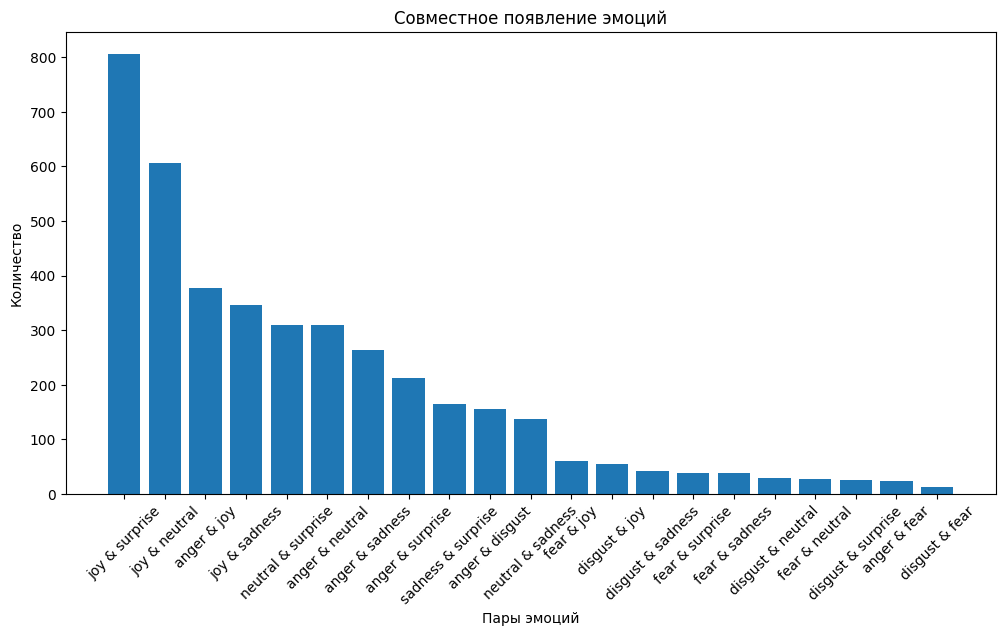

In [ ]:
plot_combined_emotions(data["train"])